In [1]:
import pandas as pd
import numpy as np
import scipy

from cmapPy.pandasGEXpress.GCToo import GCToo
from cmapPy.pandasGEXpress.parse import parse

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
gct = parse('data/PAAD.gct')
data = gct.data_df
meta_col = gct.col_metadata_df
meta_row = gct.row_metadata_df

In [3]:
data.shape, meta_col.shape, meta_row.shape

((18465, 183), (183, 124), (18465, 0))

In [4]:
# unique columns : sample types
set([col.split('-')[1] for col in data.columns])

{'Metastatic', 'Primary solid Tumor', 'Solid Tissue Normal'}

In [5]:
cols = [print(col) for col in meta_col.columns]
print(len(cols))


participant_id
sample_type
mRNAseq_cluster
bcr_patient_barcode
bcr_patient_uuid
vital_status
days_to_death
days_to_last_followup
additional_studies
adenocarcinoma_invasion
age_at_initial_pathologic_diagnosis
alcohol_history_documented
alcoholic_exposure_category
amount_of_alcohol_consumption_per_day
anatomic_neoplasm_subdivision
anatomic_neoplasm_subdivision_other
b_symptoms
bcr
bcr_aliquot_uuid
bcr_canonical_reason-2
bcr_canonical_reason-3
bcr_canonical_reason
bcr_followup_barcode
bcr_followup_uuid
bcr_patient_canonical_status
clinical_m
clinical_n
clinical_stage
clinical_t
course_number
day_of_dcc_upload
day_of_form_completion
days_to_birth
days_to_diabetes_onset
days_to_index
days_to_initial_pathologic_diagnosis
days_to_pancreatitis_onset
days_to_psa
disease_code
drugs
ethnicity
extranodal_involvement
family_history_of_cancer
file_uuid
follow_ups
followup_case_report_form_submission_reason
followup_treatment_success
frequency_of_alcohol_consumption
gender
gleason_score
histologic_gr

In [14]:
for hist, meta in meta_col.groupby('histological_type'):
    print(hist, ':')
    for hist_other, other_meta in meta.groupby('histological_type_other'):
        print('\t', hist_other)

pancreas-adenocarcinoma ductal type :
pancreas-adenocarcinoma-other subtype :
	 82463 neuroendocrine carcinoma nos
	 adenocarcinoma, nos
	 adenocarcinoma- nos
	 ductal and micropapillary
	 intraductal tubulopapillary neoplasm
	 invasive adenocarcinoma
	 invasive, well-differentiated
	 moderately differentiated ductal adenocarcinoma 60% + neuroendocrine 40%
	 neuroendocrine
	 neuroendocrine carcinoma
	 neuroendocrine carcinoma nos
	 not specified
	 poorly differentiated adenocarcinoma
	 poorly differentiated pancreatic adenocarcinoma
pancreas-colloid (mucinous non-cystic) carcinoma :
pancreas-undifferentiated carcinoma :


In [16]:
# neuroendocrine ids 
nids = []
for hist_other, other_meta in meta_col.groupby('histological_type_other'):
    if 'neuroendocrine' in hist_other and not 'moderately' in hist_other:
        # print(len(other_meta.index))
        for id_ in other_meta.index:
            nids.append(id_)
print('#neuroendocrine : ', len(nids))

#neuroendocrine :  8


In [17]:
Y = data.columns.tolist()
for i, id_ in enumerate(Y):
    Y[i] = 0
    if id_ in nids:
       Y[i] = 1
Y = np.array(Y)

count     183.000000
mean      737.453552
std       264.169332
min       294.000000
25%       564.000000
50%       697.000000
75%       837.500000
max      1944.000000
dtype: float64


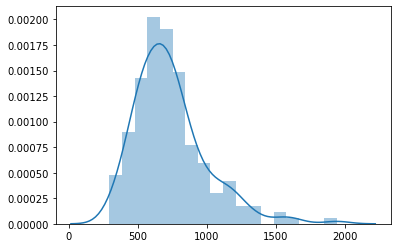

In [18]:
# missing gene values per sample
missing = data.shape[0] -  data.count()
print(missing.describe())
sns.distplot(missing)

In [19]:
# transpose data
data = data.T

count    18465.000000
mean         7.308638
std         22.106567
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        128.000000
dtype: float64


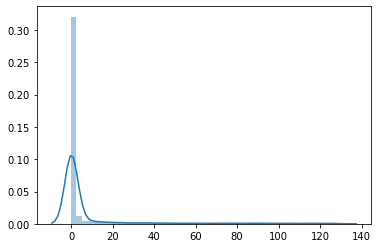

In [20]:
# look for missing nan values for each gene
missing = data.shape[0] -  data.count()
print(missing.describe())
sns.distplot(missing)

In [26]:
# Using KNN based imputer for missing values ref: https://academic.oup.com/bib/article/12/5/498/268546
# X = SimpleImputer(strategy='constant', fill_value=0).fit_transform(X)
X = data.to_numpy()
X = KNNImputer(n_neighbors=5).fit_transform(X)
X = StandardScaler().fit_transform(X)

In [23]:
# # of neoendocrine samples in test data 
print('# of neoendocrine samples in test data :', y_test.sum())

# of neoendocrine samples in test data : 3


In [0]:
pca = PCA(n_components=20, random_state=42)
componenets = pd.DataFrame(pca.fit_transform(X))

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(y_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


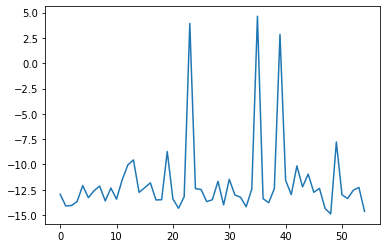

In [24]:
lr = LogisticRegression(penalty='l2')
lr.fit(x_train, y_train)
sns.lineplot(data=lr.decision_function(x_test))

In [25]:
print(lr.score(x_test, y_test))

1.0


In [0]:
sns.lineplot(data=list(lr.coef_))

In [0]:
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(x_train, y_train)
lr.score(x_test, y_test)
sns.lineplot(data=list(lr.coef_))

In [0]:
pd.DataFrame(pca.explained_variance_ratio_).plot.bar()

In [0]:
componenets['labels'] = Y

In [0]:
componenets.columns = list(map(str, componenets.columns))
sns.scatterplot(x='0', y='1', hue='labels', data=componenets)

In [0]:
inertias = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(componenets.iloc[:,:3])
    inertias.append(kmeans.inertia_)
plt.plot(range(1,10), inertias, '-o')
plt.show()
# elbows at k=3
components = componenets.iloc[:,:3]

In [0]:
# K-Means using k=3 clusters on first 3 principal components
kmeans = KMeans(n_clusters=3, random_state=42).fit(componenets.iloc[:,:3])
componenets['predict'] = kmeans.predict(componenets.iloc[:,:3])
sns.scatterplot(x='0', y='1', style='predict', hue='labels', data=componenets)

In [0]:
# missclassifications 
componenets['histological_type'] = meta_col['histological_type'].values
componenets['histological_type_other'] = meta_col['histological_type_other'].values
componenets[['labels', 'predict', 'histological_type', 'histological_type_other']][componenets.predict == 1]

In [0]:
# remove neuroendocrine 
delete = componenets[['labels', 'predict', 'histological_type', 'histological_type_other']][componenets.predict == 1].index
data2 = data.drop(index=[data.index[i] for i in delete])
meta_col2 = meta_col.drop(index=[data.index[i] for i in delete])
data2.shape, meta_col2.shape

In [0]:
# Load IFNS 
ifns = []
with open('data/type1_IFN.txt', 'r') as f:
    ifns = f.read().split('\n')
print('ifns :', len(ifns))
check = True
for ifn in ifns:
    check = check and ifn in data.columns
print('all present :', check)


In [0]:
plt.figure(figsize=(15,10))
sns.boxplot(data=data2[ifns])


In [0]:
import argparse, sys, os
import pandas as pd 
# from tempfile import mkdtemp, gettempdir
from subprocess import Popen, PIPE
import subprocess

# R GSVA function call params:
method='gsva'
kcdf='Gaussian'
abs_ranking=False
min_sz=1
max_sz=None
parallel_sz=0
parallel_type="SOCK"
mx_diff_options=[True, False] # two gsva calculations as on Hänzelmann, S., Castelo, R. & Guinney, J. GSVA
tau=None
ssgsea_norm=True
verbose=False
tempdir= None

df = data2.T
genset = pd.DataFrame(data={'name': ['type1ifn' for i in range(len(ifns))], 'member': ifns})

os.mkdir('temp')
df.to_csv('temp/expr.csv')

members = genset['member'].unique()
genset = genset.groupby(['name']).apply(lambda x: "\t".join(sorted(list(x['member'])))).reset_index().rename(columns={0:'members'})
# Write our gene sets
with open('temp/gs.gmt','w') as f:
    for row in genset.itertuples():
        name = row.name
        description = 'description'
        fields = row.members
        f.write(name+"\t"+description+"\t"+fields+"\n")
cur = os.path.dirname(os.path.realpath(__file__))
temp = os.path.join(os.path.dirname(os.path.realpath(__file__)), 'temp')
rscript = os.path.join(cur, 'gsva.r')
for mx_diff in mx_diff_options:
    cmd = ["Rscript", rscript]
    cmd += [str(x) for x in [method,kcdf,abs_ranking,min_sz,max_sz,parallel_sz,parallel_type,mx_diff,tau,ssgsea_norm,verbose,temp]]
    print('Rscript command to execute : ')
    print(cmd)
    result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
    print(result.stdout.decode('utf-8'))
    os.rename('temp/gsva_scores.csv', f'temp/gsva_scores_mx_diff_{"t" if mx_diff else "f"}.csv')

In [0]:
gsva_scores = pd.read_csv('temp/gsva_scores_mx_diff_t.csv').iloc[:,1:]
gsva_scores = gsva_scores.append(pd.read_csv('temp/gsva_scores_mx_diff_f.csv').iloc[:,1:])
gsva_scores.index = ['mx_diff_true', 'mx_diff_false']
gsva_scores

In [0]:
plt.figure(figsize=(10,5))
plt.title('Difference between largest positive and negative deviations')
sns.distplot(gsva_scores.loc['mx_diff_true'], axlabel='GSAV Score')

In [0]:
plt.figure(figsize=(10,5))
plt.title('Maximum deviation from Zero')
sns.distplot(gsva_scores.loc['mx_diff_false'], axlabel='GSAV Score')